## Data Dreamers Semester 1 Project



Created by: Habib Khadri, Nick Kirbabas, Seerat Mutneja, Sidhya Raman, Douglas Riggs, Andrew Yang

# Introduction

This is the semester 1 Capstone project for team Data Dreamers. We'll give an overview of the business problem, a walkthrough of the data, explain how we prepared the data, show our analysis of the data, and show the statistical analysis we performed.

# Business Understanding

Our client and business stakeholder, Computing Vision, an established company making a new movie studio, is trying to find ways to gain a competitive advantage within a filmmaking industry.

In order to do so, they need to understand what types of films are currently doing the best at the box office to optimize their content and successfully create a new movie studio.  

# Data Exploration & Cleaning

First, we'll import all packages we could potentially use, as well as creating our databse connection.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
# You'll need to unzip the db locally.
conn = sqlite3.connect('zippedData/im.db')

Now, let's prepare the first set of data that we'll use, tn movie budgets. From this database, we'll be heavily using the production budget and worldwide gross as our metric on how successful a movie is. We'll also use the release data to see if a movies release time affects its performance.

In [2]:
# load tn dataset and clean up columns regarding budget and gross profit
from datetime import datetime
tn_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz").drop("id", axis = 1)
tn_df["production_budget"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["domestic_gross"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["worldwide_gross"].replace(["\$",","], "", regex = True, inplace = True)

# convert budget and profit columns to numeric
cols = ["production_budget","domestic_gross","worldwide_gross"]
tn_df[cols] = tn_df[cols].apply(pd.to_numeric)

# created new columns to grab date information (day, week of year, month, etc.)
tn_df["datetime"] = [datetime.strptime(d, "%b %d, %Y") for d in tn_df["release_date"]]
tn_df["release_weeknum"] = [d.isocalendar()[1] for d in tn_df["datetime"]]
tn_df["release_weekday"] = [d.weekday() for d in tn_df["datetime"]]
tn_df["release_month"] = [d.month for d in tn_df["datetime"]]
tn_df["release_year"] = [d.year for d in tn_df["datetime"]]

# calc movie seasonal info (came out on a weekend, calander season)
tn_df["weekend"]  = np.where((tn_df["release_weekday"]== 5) |
                                  (tn_df["release_weekday"]== 6),
                                    1, 0)   

tn_df.head(5)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009-12-18,51,4,12,2009,0
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011-05-20,20,4,5,2011,0
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019-06-07,23,4,6,2019,0
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015-05-01,18,4,5,2015,0
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017-12-15,50,4,12,2017,0


Next, we'll read in bom movie gross. From this dataset, we'll only be using the studio, since we already have budgets from the tn dataset.

In [3]:
# cleaned up dataset by gathering gross profit values
bom_df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
bom_df["foreign_gross"].replace(",","", regex = True, inplace = True)
bom_df["foreign_gross"] = pd.to_numeric(bom_df["foreign_gross"])
bom_df["foreign_gross"].fillna(bom_df["foreign_gross"].median(), inplace = True)
bom_df["domestic_gross"].fillna(bom_df["domestic_gross"].median(), inplace = True)
# bom_df.dropna(subset = ["studio"], inplace = True)
bom_df.head(5)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


Finally, we'll be grabbing data from 2 tables in the IMDB dataset, movie_basics and movie_ratings. This gives us the genres and runtime data that we'll be using later. We also grab information on ratings and the number of votes for each rating - while they're not used in our final notebook, they were thing we looked into when trying to find valuable characteristics.

In [4]:
# Grab movie basics info along with average ratings for each from imdb dataset
imdb_df = pd.read_sql('''
SELECT *
FROM movie_basics
    LEFT JOIN movie_ratings USING("movie_id")
''',conn)

In [5]:
# Data cleaning to get genre count and runtime minutes
imdb_df.dropna(subset = ["genres"], inplace = True)
imdb_df["runtime_minutes"] = imdb_df["runtime_minutes"].fillna(imdb_df["runtime_minutes"].mean())
imdb_df["averagerating"] = imdb_df["averagerating"].fillna(imdb_df["averagerating"].mean())
imdb_df["numvotes"] = imdb_df["numvotes"].fillna(imdb_df["numvotes"].median())
imdb_df["genres_list"] = [gs.split(",") for gs in imdb_df["genres"]]
imdb_df["genres_count"] = [len(gs) for gs in imdb_df["genres_list"]]
imdb_df = imdb_df[imdb_df["runtime_minutes"] <= 300]
imdb_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count
0,tt0063540,Sunghursh,Sunghursh,2013,175.000000,"Action,Crime,Drama",7.0,77.0,"[Action, Crime, Drama]",3
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama",7.2,43.0,"[Biography, Drama]",2
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama,6.9,4517.0,[Drama],1
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,86.261902,"Comedy,Drama",6.1,13.0,"[Comedy, Drama]",2
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy",6.5,119.0,"[Comedy, Drama, Fantasy]",3


## Join IMDB, BOM and TN Movie Budgets

Now, we'll join the 3 datasets that we loaded. We'll use both movie title and release year to make sure that our resulting data is correct. We'll use inner joins, since we've already dealt with null values that we are able to handle.

In [6]:
# merging datasets imdb (cleaned) and bom (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c = imdb_df.merge(bom_df, how = "inner", 
                          left_on = ["primary_title", "start_year"], 
                          right_on = ["title","year"])
imdb_df_c.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378.0,"[Action, Crime, Drama]",3,Wazir,Relbig.,1100000.0,18700000.0,2016
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886.0,"[Adventure, Drama, Romance]",3,On the Road,IFC,744000.0,8000000.0,2012


In [7]:
# merging datasets imdb_c (cleaned) and tn (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c2 = imdb_df_c.merge(tn_df, how = "inner", 
                             left_on = ["primary_title", "start_year"], 
                             right_on = ["movie","release_year"])

# create release season of movies
seasons = []
for m in imdb_df_c2["release_month"]:
    if(m in [12,1,2]): 
        seasons.append("winter")
    elif(m in [3,4,5]): 
        seasons.append("spring")
    elif(m in [6,7,8]): 
        seasons.append("summer")
    else: 
        seasons.append("fall")

imdb_df_c2["release_season"] = seasons 

# create worldwide profit, adjusted for production budge
imdb_df_c2["adjusted_worldwide"] = imdb_df_c2["worldwide_gross"] - imdb_df_c2["production_budget"]

# it's beautiful
imdb_df_c2.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,release_season,adjusted_worldwide
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300.0,"[Adventure, Comedy, Drama]",3,...,58236838,187861183,2013-12-25,52,2,12,2013,0,winter,96861183
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116.0,"[Action, Crime, Drama]",3,...,26017685,62108587,2014-09-19,38,4,9,2014,0,fall,34108587


## EDA

These are a few old graphs which we created when testing things that affected movie performance - this section is not important, and can be skipped

<ipython-input-8-a8ec1373fbc0>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


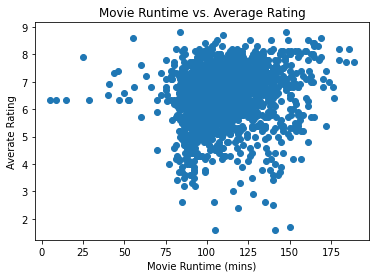

In [8]:
fig, ax = plt.subplots()
ax.scatter(imdb_df_c["runtime_minutes"], imdb_df_c["averagerating"])
ax.set_title("Movie Runtime vs. Average Rating")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Averate Rating")
fig.show()

Text(0, 0.5, 'Frequency')

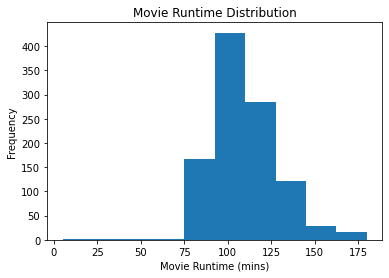

In [9]:
fig, ax = plt.subplots()
ax.hist(imdb_df_c2["runtime_minutes"])
ax.set_title("Movie Runtime Distribution")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

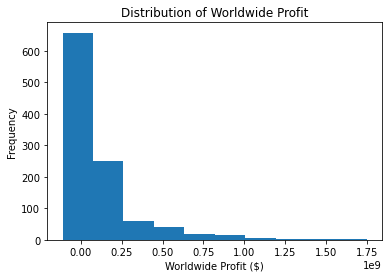

In [10]:
fig, ax = plt.subplots()
ax.hist(imdb_df_c2["adjusted_worldwide"])
ax.set_title("Distribution of Worldwide Profit")
ax.set_xlabel("Worldwide Profit ($)")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Relative Frequency')

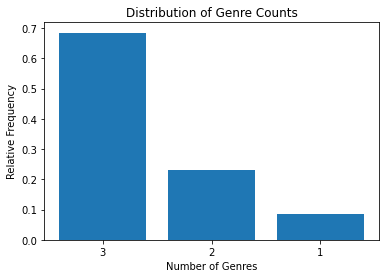

In [11]:
g_count = imdb_df_c2["genres_count"].value_counts(normalize  = True)
labs = [str(x) for x in g_count.index]
fig, ax = plt.subplots()
ax.bar(labs, g_count)
ax.set_title("Distribution of Genre Counts")
ax.set_xlabel("Number of Genres")
ax.set_ylabel("Relative Frequency")

# Metric 1: Genre

The first thing we want to check is which genre is the most profitable. To do this, we'll have to group the movies by genre to see how the average movie in each genre performs. First, let's take a look at our table:

In [12]:
imdb_df_c2.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,release_season,adjusted_worldwide
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300.0,"[Adventure, Comedy, Drama]",3,...,58236838,187861183,2013-12-25,52,2,12,2013,0,winter,96861183
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116.0,"[Action, Crime, Drama]",3,...,26017685,62108587,2014-09-19,38,4,9,2014,0,fall,34108587


Seems like most movies have more then 1 genre. We'll have to split out the genres to get information on how well each separated genre performs. This is not ideal, as there may be heavy correlation between genres that are commonly used together, but it's the best we can do.

In [13]:
# Splitting the genre column into separate rows for each listed genre
imdb_tn_split_df = imdb_df_c2.copy()
imdb_tn_split_df = pd.DataFrame({'genres':imdb_tn_split_df.genres.str.split(','),\
                                 'movie':imdb_tn_split_df.primary_title}, )\
                                .explode('genres')

In [14]:
# Check that the result looks as expected
imdb_tn_split_df.head(2)

,genres,movie
0,Adventure,The Secret Life of Walter Mitty
0,Comedy,The Secret Life of Walter Mitty


In [15]:
# Join back with the original dataframe to get the rest of the columns, 
# since we only have genre and movie name.
imdb_tn_split_df = imdb_tn_split_df.set_index('movie');
imdb_tn_df = imdb_df_c2.copy().set_index('primary_title')
imdb_tn_split_df = imdb_tn_split_df\
.join(imdb_tn_df, how='inner', lsuffix='_separated', rsuffix='_original')
imdb_tn_split_df.reset_index()
imdb_tn_df.reset_index();

In [16]:
# Create a column for profit ratio, just as an additional thing to look at
imdb_tn_split_df['profit_ratio'] = \
    imdb_tn_split_df.adjusted_worldwide / imdb_tn_split_df.production_budget

In [17]:
# Check the result
imdb_tn_split_df.head(2)

,genres_separated,movie_id,original_title,start_year,runtime_minutes,genres_original,averagerating,numvotes,genres_list,genres_count,...,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,release_season,adjusted_worldwide,profit_ratio
10 Cloverfield Lane,Drama,tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",7.2,260383.0,"[Drama, Horror, Mystery]",3,...,108286422,2016-03-11,10,4,3,2016,0,spring,103286422,20.657284
10 Cloverfield Lane,Horror,tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",7.2,260383.0,"[Drama, Horror, Mystery]",3,...,108286422,2016-03-11,10,4,3,2016,0,spring,103286422,20.657284


Alright, seems like we now have 1 genre per row, which is what we wanted. Now, we can group by genre using aggregate functions to see how each genre performs.

In [18]:
# Group by genre. Use aggregate functions on columns of interest. Lots of these
# were exploratory, and will not be used.
genre_df = imdb_tn_split_df.groupby('genres_separated').agg({
#     'numvotes': ['mean', 'median'],
    'production_budget': ['mean', 'median', 'sum'],
#     'domestic_gross': ['mean', 'median'],
    'worldwide_gross': ['mean', 'median'],
    'profit_ratio': ['mean', 'median'],
    'adjusted_worldwide': ['mean', 'median', 'sum'],
    'genres_count': 'mean',
    'movie_id': 'count'
})

In [19]:
# Take a look at the full dataframe, since it is a small dataset.
genre_df

production_budget                         worldwide_gross  \
                              mean     median          sum            mean   
genres_separated                                                             
Action                8.779154e+07   61000000  29059000000    2.780253e+08   
Adventure             1.119676e+08  110000000  31462900000    3.825006e+08   
Animation             1.068529e+08  100000000   9082500000    4.295505e+08   
Biography             2.812518e+07   24000000   3093770000    9.280534e+07   
Comedy                4.534798e+07   30000000  17957800000    1.603209e+08   
Crime                 3.499651e+07   30000000   5809420000    9.864854e+07   
Documentary           1.610714e+07    7500000    451000000    5.138317e+07   
Drama                 2.969809e+07   20000000  15858782650    8.531012e+07   
Family                6.907424e+07   42500000   4558900000    1.755538e+08   
Fantasy               8.685275e+07   60000000   7903600000    2.359459e+08   
History               4.100000e+07   29000000   1230000000    1.119801e+08   
Horror                2.388103e+07   10000000   2770200000    1.041640e+08   
Music                 2.168611e+07   18000000    780700000    9.807032e+07   
Musical               5.446000e+07   55000000    272300000    1.359261e+08   
Mystery               2.745397e+07   12000000   2333587650    1.119684e+08   
Romance               2.233699e+07   18500000   3305875000    7.327936e+07   
Sci-Fi                1.049518e+08  100000000  10075375000    3.999846e+08   
Sport                 2.842857e+07   25000000    597000000    6.791182e+07   
Thriller              3.800690e+07   25000000   7373337650    1.400274e+08   
War                   2.614286e+07   20000000    183000000    5.670213e+07   
Western               7.875000e+07   38500000    472500000    1.633628e+08   

                              profit_ratio           adjusted_worldwide  \
                       median         mean    median               mean   
genres_separated                                                          
Action            140783360.0     2.003238  1.399305       1.902338e+08   
Adventure         274392649.0     2.351914  1.779868       2.705330e+08   
Animation         349088523.0     3.062197  2.292976       3.226976e+08   
Biography          46221328.5     2.803890  1.318634       6.468016e+07   
Comedy             82996305.0     2.711723  1.668306       1.149729e+08   
Crime              59937456.5     1.604408  1.175322       6.365203e+07   
Documentary        26852455.5     3.939128  1.728412       3.527603e+07   
Drama              46495248.0     2.799239  1.238710       5.561202e+07   
Family            100502080.0     1.697618  1.076189       1.064795e+08   
Fantasy            91678442.0     2.396156  1.182820       1.490932e+08   
History            82616153.5     2.165345  1.349481       7.098012e+07   
Horror             68475760.5    12.274592  3.074923       8.028301e+07   
Music              59518767.5     3.409234  2.225932       7.638421e+07   
Musical            90552675.0     1.978332  0.646412       8.146606e+07   
Mystery            82925064.0    12.380021  3.321870       8.451440e+07   
Romance            46014980.5     3.208187  1.642869       5.094237e+07   
Sci-Fi            287054362.0     3.183424  2.231891       2.950328e+08   
Sport              46527161.0     1.617058  0.822305       3.948325e+07   
Thriller           69238020.0     6.893193  1.814909       1.020205e+08   
War                17769299.0     0.862093 -0.111535       3.055927e+07   
Western           130395626.5     1.273282 -0.270470       8.461276e+07   

                                           genres_count movie_id  
                       median          sum         mean    count  
genres_separated                                                  
Action             73406855.0  62967381440     2.903323      331  
Adventure         155270083.0  76019775167     2.946619      281  
Animatio

Looks good! The multi-indexed columns are a bit hard to work with, so lets go ahead and flatten them out. We should also get rid of genres with extremely low sample size, since their data is too unreliable to make any conclusions out of.

In [20]:
# Flatten column names
genre_df.columns = genre_df.columns.get_level_values(1) \
                    + '_' + genre_df.columns.get_level_values(0)

In [21]:
#  Change the name of the movie_id column, 
# which was used to count the number of movies in the genre
genre_df.columns = ['mean_production_budget', 'median_production_budget',
       'sum_production_budget', 'mean_worldwide_gross',
       'median_worldwide_gross', 'mean_profit_ratio', 'median_profit_ratio',
       'mean_adjusted_worldwide', 'median_adjusted_worldwide',
       'sum_adjusted_worldwide', 'mean_genres_count', 'movie_count'];
# Remove genres with really low samples (< 30 movies)
genre_df = genre_df[(genre_df.movie_count >= 30)].copy()

In [22]:
# Divide columns by 1000000 to easily display values in millions
genre_df['mean_adjusted_worldwide'] = genre_df['mean_adjusted_worldwide'] / 1000000
genre_df['median_adjusted_worldwide'] = genre_df['median_adjusted_worldwide'] / 1000000

## Graphs

Alright, now that our data is properly set up, we can start graphing! The first thing we want to do is to check the number of outliers so that we can decide whether to use mean or median for our graphs.

In [23]:
# Set up styling for graphs
sns.set_theme()
sns.set_style('whitegrid')
# These were to get high resolution graphs for our presentation,
# not needed otherwise
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

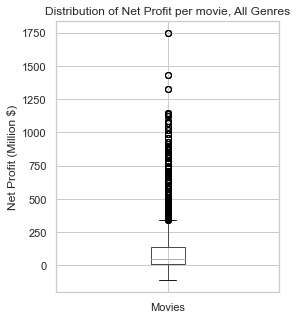

In [24]:
# Create a box and whiskers plot of median profit, 
# to see what the distribution of values looks like
fig, ax = plt.subplots(figsize=(4,5))
millions_df = imdb_tn_split_df[['genres_separated', 'adjusted_worldwide']].copy()
millions_df.adjusted_worldwide = millions_df.adjusted_worldwide / 1000000
millions_df.columns = ['genres_separated', 'Movies']
millions_df\
.boxplot(column='Movies', ax=ax)
ax.set(title='Distribution of Net Profit per movie, All Genres',\
       ylabel='Net Profit (Million $)');


Seems like there are lots of outliers! For our genre graphs we can use the median to mitigate the effect of the outliers.

Lets take a look at a graph of net profit, to see which types of movies create the most profit!

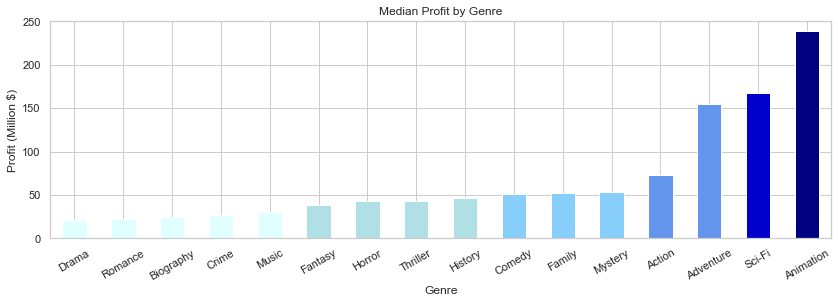

In [25]:
# Graph of how much profit a movie in each genre made, by median value
fig, ax = plt.subplots(figsize=(14,4))
genre_df = genre_df.sort_values('median_adjusted_worldwide')
net_profit = genre_df.median_adjusted_worldwide
net_profit.plot.bar(ax=ax, color=\
     ["lightcyan" if (x < net_profit.quantile(.3)) \
      else 'powderblue' if (x < net_profit.quantile(.6))
      else 'lightskyblue' if (x < net_profit.quantile(.8))
      else 'cornflowerblue' if (x < net_profit.quantile(.9))
      else 'mediumblue' if (x < net_profit.quantile(.95))
      else 'navy' for x in net_profit]);
ax.set(title='Median Profit by Genre', xlabel='Genre', \
       ylabel='Profit (Million $)');
plt.xticks(rotation=30);

Seems like Animation, Sci-Fi, and Adventure made the most profit-wise. However, the Animation genre has a few abnormalities which make it hard to recommend. Animation isn't necessarily a genre itself, it's just a style of movie - every animation movie would have another genre which is its actual genre. Animation studios are also radically different from normal movie studios, and have a high barrier to entry, so it isn't really something we want to recommend for Computing Vision. So it would be best to exclude it from our analysis.

Let's make a graph without Animation!

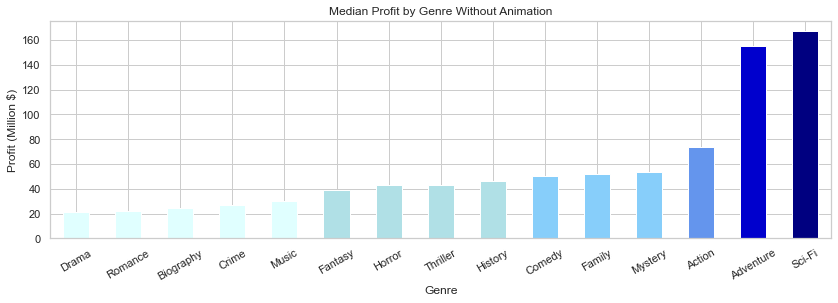

In [26]:
# Graph of how much profit a movie in each genre made, by median value, without 
# animation
fig, ax = plt.subplots(figsize=(14,4))
genre_df = genre_df.sort_values('median_adjusted_worldwide')
net_profit = genre_df[genre_df.index != 'Animation'].median_adjusted_worldwide
net_profit.plot.bar(ax=ax, color=\
     ["lightcyan" if (x < net_profit.quantile(.3)) \
      else 'powderblue' if (x < net_profit.quantile(.6))
      else 'lightskyblue' if (x < net_profit.quantile(.8))
      else 'cornflowerblue' if (x < net_profit.quantile(.9))
      else 'mediumblue' if (x < net_profit.quantile(.95))
      else 'navy' for x in net_profit]);
ax.set(title='Median Profit by Genre Without Animation', xlabel='Genre', \
       ylabel='Profit (Million $)');
plt.xticks(rotation=30);

Alright, that looks more useful! Seems like Sci-Fi and Adventure films are far and away the most profitable! Since we need to make a recommendation to Computing Vision, let's just pick the first one - Sci-Fi. Another benefit of Sci-Fi, which we've found through 3rd party sources, is that Sci-Fi movies are great for merchandise sales, a source of revenue which is not included in our graphs. So Sci-Fi seems like a greate genre to reccomend!

In [55]:
# Get median profit $ of Sci-Fi movies.
genre_df[genre_df.index == 'Sci-Fi'].median_adjusted_worldwide

genres_separated
Sci-Fi    167.054362
Name: median_adjusted_worldwide, dtype: float64

Before we move on, let's look at the profit ratio to make sure this is a good use of our money. While Sci-Fi movies are the most profitable, it is possible that they are inefficient, and it might be better to pick a genre with a higher ratio of profit if that is the case.

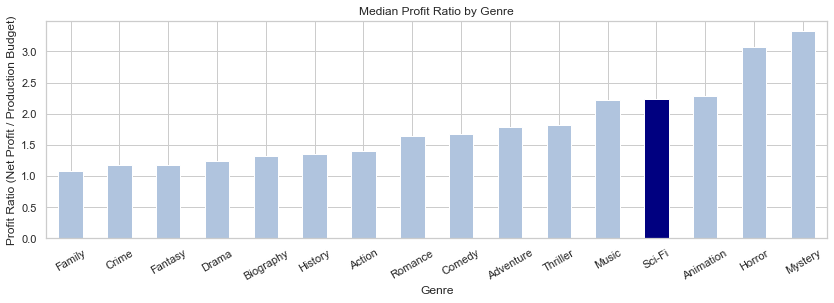

In [28]:
fig, ax = plt.subplots(figsize=(14,4))
genre_df = genre_df.sort_values('median_profit_ratio')
genre_df.median_profit_ratio.plot.bar(ax=ax, color=\
     ["navy" if (x == 'Sci-Fi' ) \
      else 'lightsteelblue' for x in genre_df.index]);
ax.set(title='Median Profit Ratio by Genre', xlabel='Genre', \
       ylabel='Profit Ratio (Net Profit / Production Budget)');
plt.xticks(rotation=30);

Si-Fi is in the top 4, so it seems like the money put into a Sci-Fi movie results in a high profit too! Great! Also notable is that adventure is several spots lower than Sci-Fi on this list, giving us another reason to stick with Sci-Fi.

# Metric 2: Season

## Hypothesis Testing

### Runtime and Adjusted Worldwide Profit

H0: Movies longer than two hours do not make more worldwide profit than those shorter than two hours.

Ha: Movies longer than two hours do make more worldwide profit than those shorter than two hours.

In [29]:
import scipy.stats as stats

In [30]:
# divide movies by runtime; movies longer or equal to 2 hours are long movies
long_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]>= 120]
short_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]< 120]

In [31]:
# conduct two-sample t-test (independent)
results = stats.ttest_ind(long_movies["adjusted_worldwide"], 
                          short_movies["adjusted_worldwide"])
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 8.59996881426426.
The p-value is 2.865776372867499e-17.
We reject the null hypothesis at an alpha level of 0.05.


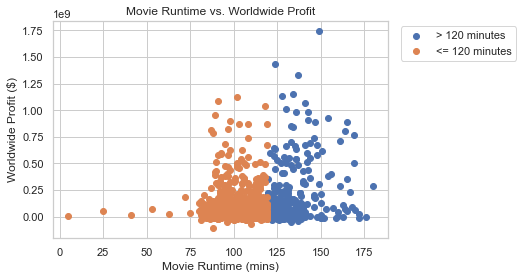

In [32]:
# Display split between long and short movie adjusted worldwide profit
fig, ax = plt.subplots()
sns.set_style('whitegrid')
ax.scatter(long_movies["runtime_minutes"], long_movies["adjusted_worldwide"], label='> 120 minutes')
ax.scatter(short_movies["runtime_minutes"], short_movies["adjusted_worldwide"], label='<= 120 minutes')
ax.set_title("Movie Runtime vs. Worldwide Profit")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Worldwide Profit ($)")
ax.legend(bbox_to_anchor = (1.40, 1));
# fig.show()

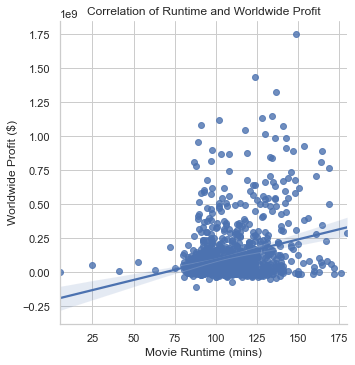

In [33]:
# try drawing a correlation line, visualize correlation
import seaborn as sns
p = sns.lmplot(x ='runtime_minutes', y ='adjusted_worldwide', data = imdb_df_c2)
p.set(title = "Correlation of Runtime and Worldwide Profit")
p.set(xlabel = "Movie Runtime (mins)", ylabel = "Worldwide Profit ($)");

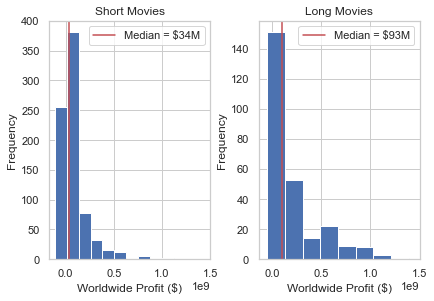

In [34]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[1].hist(long_movies["adjusted_worldwide"], bins = 10)
ax[0].hist(short_movies["adjusted_worldwide"], bins = 10)

ax[1].set_title("Long Movies")
ax[1].set_xlabel("Worldwide Profit ($)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(right = 1.5 * 10**9)
ax[1].axvline(long_movies["adjusted_worldwide"].median(), color = "r")
ax[1].legend(loc='upper right',\
     labels=['Median = ${}M'.format(int(round(long_movies["adjusted_worldwide"].median()/1000000)))])

ax[0].set_title("Short Movies")
ax[0].set_xlabel("Worldwide Profit ($)")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(right = 1.5 * 10**9)
ax[0].axvline(short_movies["adjusted_worldwide"].median(), color = "r")
ax[0].legend(loc='upper right',\
     labels=['Median = ${}M'.format(int(round(short_movies["adjusted_worldwide"].median()/1000000)))]);

### Genre Count and Adjusted Worldwide Profit

H0: Movies that occupy three genres do not have higher worldwide profit than those with only one or two genres.

Ha: Movies that occupy three genres do have higher worldwide profit than those with only one or two genres.

In [35]:
genres_3 = imdb_df_c2[imdb_df_c2["genres_count"]== 3]
genres_1or2 = imdb_df_c2[imdb_df_c2["genres_count"]!= 3]

In [36]:
results = stats.ttest_ind(genres_3["adjusted_worldwide"], 
                          genres_1or2["adjusted_worldwide"])
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 6.095964529296253.
The p-value is 1.5263761639090117e-09.
We reject the null hypothesis at an alpha level of 0.05.


Text(0, 0.5, 'Worldwide Profit ($)')

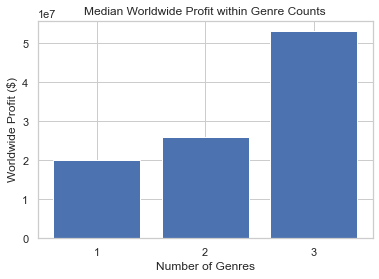

In [37]:
g_adjWW = imdb_df_c2.groupby("genres_count").median()["adjusted_worldwide"]
labs2 = [str(x) for x in g_adjWW.index]
fig, ax = plt.subplots()
ax.bar(labs2, g_adjWW)
ax.set_title("Median Worldwide Profit within Genre Counts")
ax.set_xlabel("Number of Genres")
ax.set_ylabel("Worldwide Profit ($)")

### Movie Budget and Adjusted Worldwide Profit

H0: Movies with higher budgets do not have larger worldwide profit than those with smaller budgets on average.

Ha: Movies with higher budgets do have larger worldwide profit than those with smaller budgets.

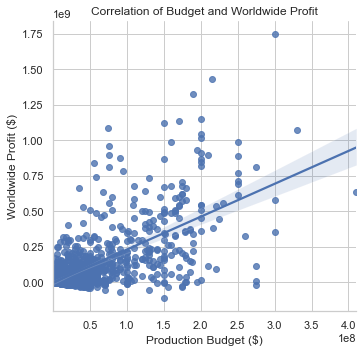

In [38]:
import seaborn as sns
sns.set_style('whitegrid')
p = sns.lmplot(x ='production_budget', y ='adjusted_worldwide', data = imdb_df_c2)
p.set(title = "Correlation of Budget and Worldwide Profit")
p.set(xlabel = "Production Budget ($)", ylabel = "Worldwide Profit ($)")

In [39]:
high_prod = imdb_df_c2[imdb_df_c2["production_budget"] >= imdb_df_c2["production_budget"].median()]
low_prod = imdb_df_c2[imdb_df_c2["production_budget"] < imdb_df_c2["production_budget"].median()]

In [40]:
results = stats.ttest_ind(high_prod["adjusted_worldwide"], low_prod["adjusted_worldwide"])
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 13.491475791381173.
The p-value is 2.2744748958401043e-38.
We reject the null hypothesis at an alpha level of 0.05.


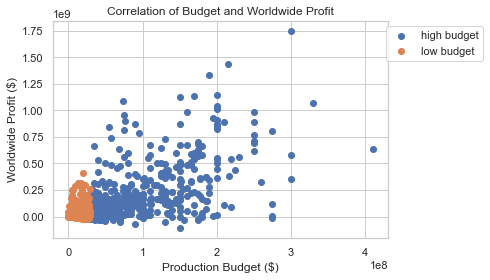

In [41]:
fig, ax = plt.subplots()
ax.scatter(high_prod["production_budget"], high_prod["adjusted_worldwide"], 
           label = "high budget")
ax.scatter(low_prod["production_budget"], low_prod["adjusted_worldwide"],
          label = "low budget")
ax.set_title("Correlation of Budget and Worldwide Profit")
ax.set_xlabel("Production Budget ($)")
ax.set_ylabel("Worldwide Profit ($)")
ax.legend(bbox_to_anchor = (1.30, 1))

### Seasons and Worldwide Profit

In [42]:
imdb_df_c2["release_season"].value_counts()

fall      335
summer    276
winter    227
spring    213
Name: release_season, dtype: int64

Text(0, 0.5, 'Median Worldwide Profit ($)')

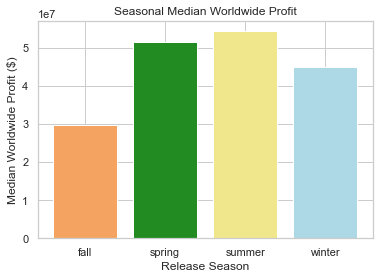

In [43]:
# group rows by release season, and get medians of each
seasonal_medians = imdb_df_c2.groupby("release_season").median()["adjusted_worldwide"]

# create barplot w/ custom colors
fig, ax = plt.subplots()
c = ['sandybrown', 'forestgreen', 'khaki', 'lightblue']
ax.bar(seasonal_medians.index, seasonal_medians, color = c)
ax.set_title("Seasonal Median Worldwide Profit")
ax.set_xlabel("Release Season")
ax.set_ylabel("Median Worldwide Profit ($)")

Text(0, 0.5, 'Mean Worldwide Profit ($)')

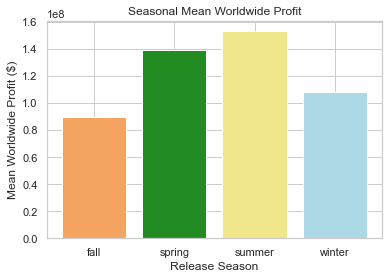

In [44]:
# group rows by release season, and get means of each
seasonal_means = imdb_df_c2.groupby("release_season").mean()["adjusted_worldwide"]

# create barplot w/ custom colors
fig, ax = plt.subplots()
c = ['sandybrown', 'forestgreen', 'khaki', 'lightblue']
ax.bar(seasonal_means.index, seasonal_means, color = c)
ax.set_title("Seasonal Mean Worldwide Profit")
ax.set_xlabel("Release Season")
ax.set_ylabel("Mean Worldwide Profit ($)")

H0: Movies that release in warmer seasons do not have larger worldwide profit than those released in colder ones.

Ha: Movies that release in warmer seasons have larger worldwide profit than those released in colder ones.

In [45]:
# only rows where season is fall or winter
cold_season = imdb_df_c2[(imdb_df_c2["release_season"] == "winter") | 
                        (imdb_df_c2["release_season"] == "fall")]

# only rows where season is spring or summer
warm_season = imdb_df_c2.loc[(imdb_df_c2["release_season"] == "summer") | 
                             (imdb_df_c2["release_season"] == "spring")]

In [46]:
results = stats.ttest_ind(warm_season["adjusted_worldwide"], cold_season["adjusted_worldwide"])
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 3.9078710753046453.
The p-value is 9.908052348640371e-05.
We reject the null hypothesis at an alpha level of 0.05.


Text(0.5, 1.0, 'Worldwide Profit between Cold and Warm Seasons')

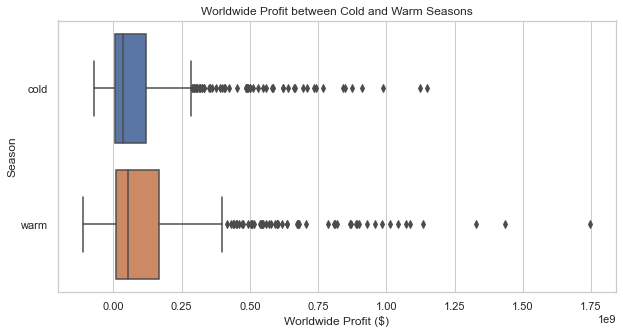

In [47]:
season_list = []
for s in imdb_df_c2["release_season"]:
    if (s == "winter") | (s == "fall"):
        season_list.append("cold")
    else:
        season_list.append("warm")

imdb_df_c2["season_split"] = season_list

fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x='adjusted_worldwide', y='season_split', data= imdb_df_c2)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_ylabel("Season")
ax.set_title("Worldwide Profit between Cold and Warm Seasons")

### Visualize the Ideal Movie

In [48]:
movie_samp = imdb_df_c2.loc[(imdb_df_c2["runtime_minutes"] >= 120) &
                           (imdb_df_c2["season_split"] == "warm") & 
                           [("Sci-Fi" in g) for g in imdb_df_c2["genres_list"]]]
movie_samp[["primary_title", "runtime_minutes", "season_split", "genres_list", 
            "adjusted_worldwide"]].sample(n=5, random_state=77777)

,primary_title,runtime_minutes,season_split,genres_list,adjusted_worldwide
316,The Wolverine,126.0,warm,"[Action, Adventure, Sci-Fi]",301456852
331,Prometheus,124.0,warm,"[Adventure, Mystery, Sci-Fi]",277448265
2,Jurassic World,124.0,warm,"[Action, Adventure, Sci-Fi]",1433854864
215,X-Men: First Class,131.0,warm,"[Action, Adventure, Sci-Fi]",195408305
576,The Amazing Spider-Man 2,142.0,warm,"[Action, Adventure, Sci-Fi]",508996336


Text(0.5, 1.0, 'Worldwide Profit of Ideal Movies')

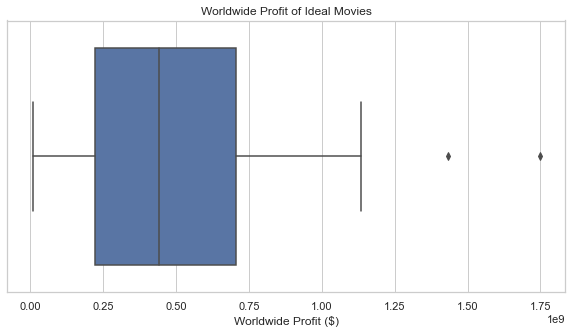

In [49]:
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x='adjusted_worldwide', data= movie_samp)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_title("Worldwide Profit of Ideal Movies")

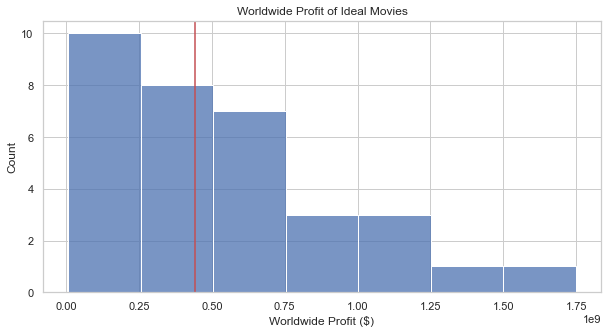

In [50]:
fig, ax = plt.subplots(figsize = (10,5))
sns.histplot(x='adjusted_worldwide', data= movie_samp)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_title("Worldwide Profit of Ideal Movies")
plt.axvline(movie_samp["adjusted_worldwide"].median(), color = "r");

In [51]:
# mean Profit
round(movie_samp["adjusted_worldwide"].mean(),2)

539822447.24

In [52]:
# median Profit
round(movie_samp["adjusted_worldwide"].median(),2)

442999518.0

In [53]:
# IQR of Profit
round(movie_samp["adjusted_worldwide"].quantile(.75),2) - round(movie_samp["adjusted_worldwide"].quantile(.25),2)

484163444.0

In [54]:
conn.close()